## Importing Libraries

In [1]:
import os
import librosa
import numpy as np
import soundfile
import IPython
import shutil

## Dataset

In [5]:
def audio_to_audio_frame_stack(sound_data, frame_length, hop_length_frame):
    """This function take an audio and split into several frame
       in a numpy matrix of size (nb_frame,frame_length)"""

    sequence_sample_length = sound_data.shape[0]
    # Creating several audio frames using sliding windows
    sound_data_list = [sound_data[start:start + frame_length] for start in range(
    0, sequence_sample_length - frame_length + 1, hop_length_frame)]  # get sliding windows
    # Combining all the frames to single matrix
    sound_data_array = np.vstack(sound_data_list)
    return sound_data_array

In [6]:
# Required variables for Audio
noisy_audio_dir="/kaggle/input/letsdoit/MIXED/content/MIXED/"
voice_dir="/kaggle/input/letsdoit/ORIGINAL/content/ORIGINAL/"
path_save_spectrogram="/content/spectogram/"
sample_rate=8000
min_duration=1.0  
frame_length=8064
hop_length_frame=8064
hop_length_frame_noise=5000
nb_samples=500
n_fft=255
hop_length_fft=63
dim_square_spec = int(n_fft / 2) + 1

In [7]:
# clean Audio files
clean_audio_files = os.listdir(voice_dir)
i=np.random.randint(1000)
# Selecting a random audio from clean speech
clean_random_audio = f"original_"+str(i).zfill(4)+".wav"
# Load Audio
y,sr = librosa.load(os.path.join(voice_dir,clean_random_audio),sr=sample_rate)
# Converting to Audio to numpy matrix
clean = audio_to_audio_frame_stack(y,frame_length,hop_length_frame)
print("Clean Audio: {}".format(clean_random_audio))
print("Shape:{}".format(clean.shape))

Clean Audio: original_0943.wav
Shape:(3, 8064)


In [8]:
# Noisy Audio files
noisy_audio_files = os.listdir(noisy_audio_dir)
# Selecting a random noisy audio from noisy audio data
noisy_random_audio = f"combined_"+str(i).zfill(4)+".wav"
# Load Audio
y,sr = librosa.load(os.path.join(noisy_audio_dir,noisy_random_audio),sr=sample_rate)
# Converting the Audio to numpy matrix
noise = audio_to_audio_frame_stack(y,frame_length,hop_length_frame)
print("Noise Audio: {}".format(noisy_random_audio))
print("Shape:{}".format(noise.shape))

Noise Audio: combined_0943.wav
Shape:(3, 8064)


For example, Let's implement this for our random noise and clean speech

In [9]:
clean = np.vstack(clean)
noise = np.vstack(noise)

In [10]:
print(clean)
print(noise)

[[-4.9854476e-05 -5.3166492e-05 -3.7051552e-05 ... -1.8141004e-03
  -1.4633232e-03  8.6855714e-04]
 [ 3.0601334e-03  5.4380536e-04 -2.4739581e-03 ... -6.3630948e-03
  -4.8912587e-03 -3.2265214e-03]
 [-4.2156596e-03 -3.9554774e-03  1.6033570e-03 ...  6.4626344e-02
   8.2381688e-02  5.5962466e-02]]
[[-0.03059404 -0.06705804 -0.02564836 ... -0.07641144 -0.09308962
  -0.06999851]
 [-0.0301534  -0.04428894 -0.06288541 ...  0.16094127  0.10993305
  -0.19716954]
 [-0.14092135  0.1557806   0.15901808 ...  0.42136213  0.3060298
   0.5656679 ]]


In [11]:
prod_voice=clean
prod_noisy_voice=noise

In [27]:
samples_clean = []
samples_noisy_clean = []
for x in clean:
  samples_clean.extend(x)

for x in noise:
  samples_noisy_clean.extend(x)

In [28]:
# After combining all samples to 1 (10*8064)
len(samples_clean)

24192

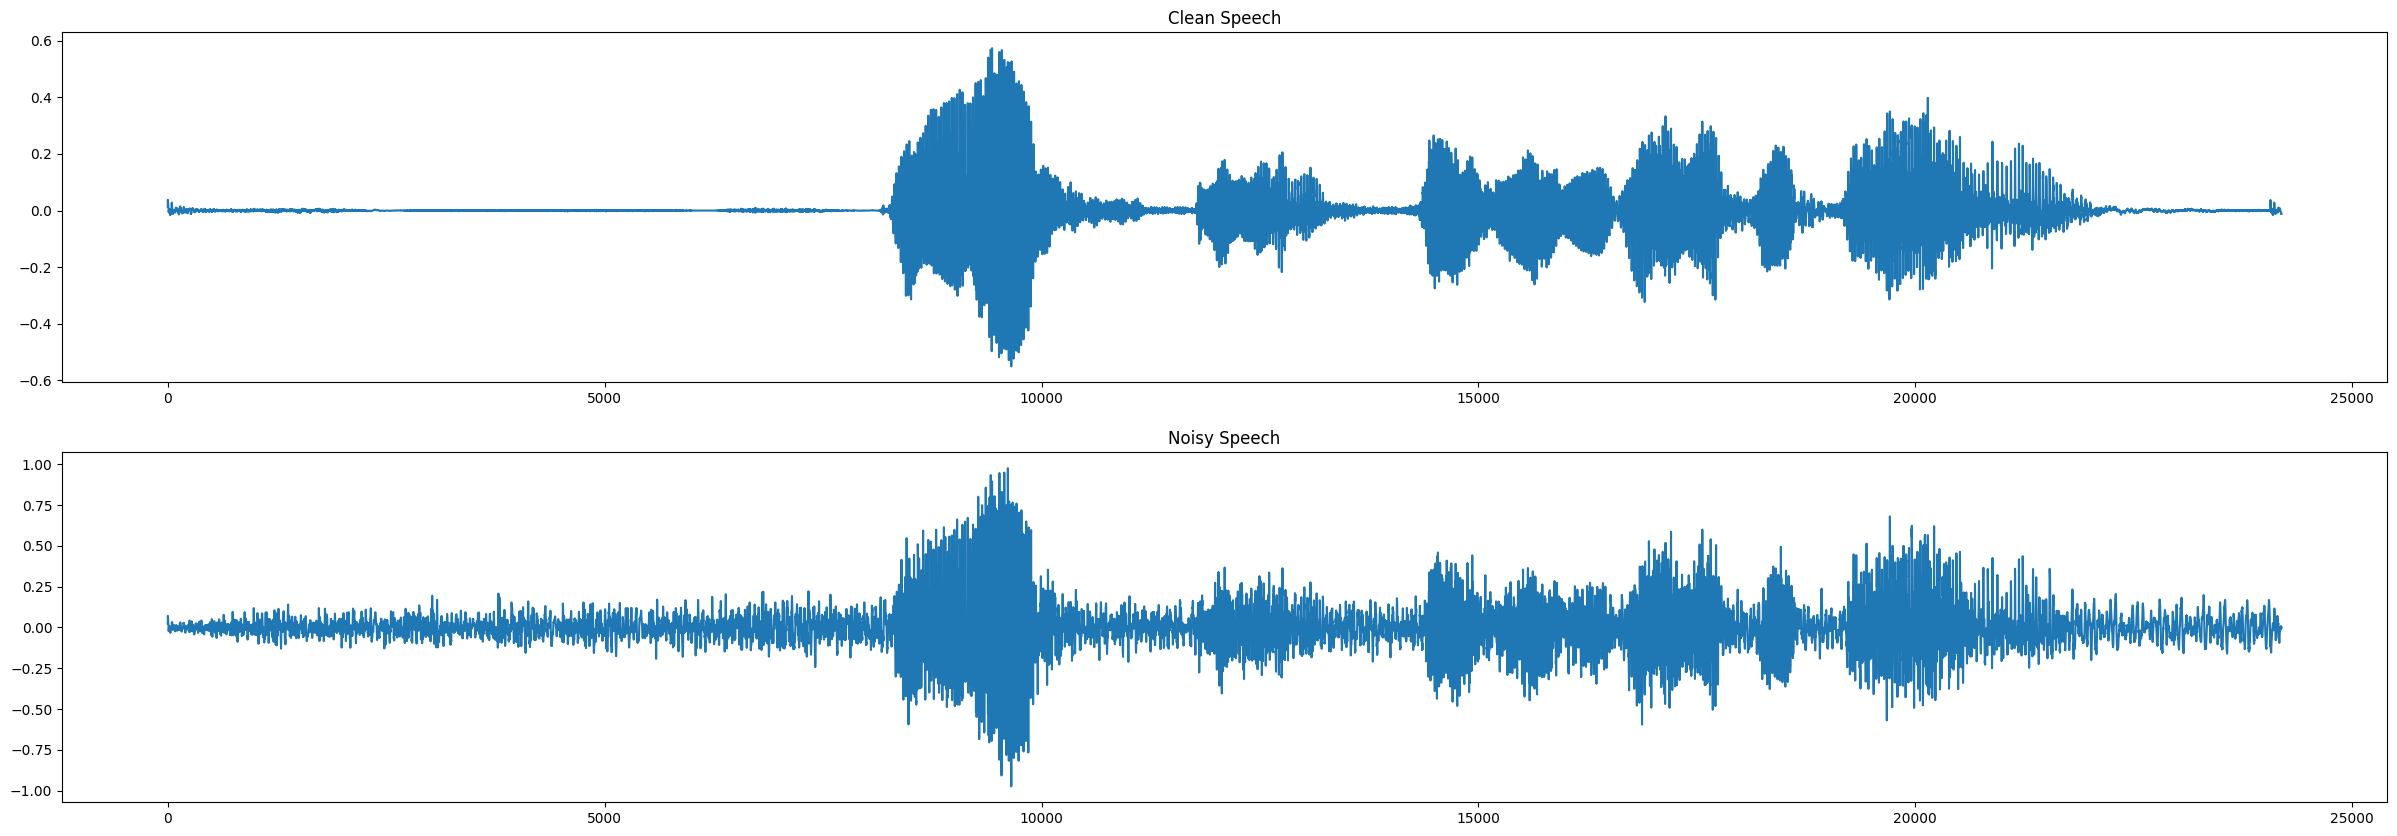

In [29]:
import matplotlib.pyplot as plt
plt.figure(figsize=(30,10))
plt.subplot(211)
plt.title("Clean Speech")
plt.plot(samples_clean)

plt.subplot(212)
plt.title("Noisy Speech")
plt.plot(samples_noisy_clean)

plt.show()

In [ ]:
# Saving and playing clean voice
import soundfile as sf
clean_nb_samples = clean.shape[0]
#Save all frames in one file
clean_long = clean.reshape(1, 3 * frame_length)*109
# librosa.output.write_wav(dir_save_prediction + audio_output_prediction, denoise_long[0, :], 1000)
sf.write("cleanAUDIO.wav", clean_long[0,:], 8000, 'PCM_24')

In [13]:
from IPython.display import Audio
Audio("cleanAUDIO.wav")

In [14]:
# Saving and playing noisy voice
noise_nb_samples = noise.shape[0]
#Save all frames in one file
noise_long = noise.reshape(1, 3 * frame_length)*10
# librosa.output.write_wav(dir_save_prediction + audio_output_prediction, denoise_long[0, :], 1000)
sf.write("noisyAUDIO.wav", noise_long[0,:], 8000, 'PCM_24')

In [15]:
from IPython.display import Audio
Audio('noisyAUDIO.wav')

In [16]:
def audio_to_magnitude_db_and_phase(n_fft, hop_length_fft, audio):
    """This function takes an audio and convert into spectrogram,
       it returns the magnitude in dB and the phase"""

    
    stftaudio = librosa.stft(audio, n_fft=n_fft, hop_length=hop_length_fft)
    stftaudio_magnitude, stftaudio_phase = librosa.magphase(stftaudio)

    stftaudio_magnitude_db = librosa.amplitude_to_db(
        stftaudio_magnitude, ref=np.max)

    return stftaudio_magnitude_db, stftaudio_phase

In [17]:
def numpy_audio_to_matrix_spectrogram(numpy_audio, dim_square_spec, n_fft, hop_length_fft):
    """This function takes as input a numpy audi of size (nb_frame,frame_length), and return
    a numpy containing the matrix spectrogram for amplitude in dB and phase. It will have the size
    (nb_frame,dim_square_spec,dim_square_spec)"""

    # we extract the magnitude vectors from the 256-point STFT vectors and 
    # take the first 129-point by removing the symmetric half.

    nb_audio = numpy_audio.shape[0]
    # dim_square_spec = 256/2
    m_mag_db = np.zeros((nb_audio, dim_square_spec, dim_square_spec))
    m_phase = np.zeros((nb_audio, dim_square_spec, dim_square_spec), dtype=complex)

    for i in range(nb_audio):
        m_mag_db[i, :, :], m_phase[i, :, :] = audio_to_magnitude_db_and_phase(
            n_fft, hop_length_fft, numpy_audio[i])
#     print(m_phase)
#     print(m_mag_db)
    return m_mag_db, m_phase

In [4]:
def audio_files_to_numpy(audio_dir, list_audio_files, sample_rate, frame_length, hop_length_frame, min_duration):
    """This function take audio files of a directory and merge them
    in a numpy matrix of size (nb_frame,frame_length) for a sliding window of size hop_length_frame"""

    list_sound_array = []

    count = 0
    for file in list_audio_files:
    # open the audio file
      try:
        y, sr = librosa.load(os.path.join(audio_dir, file), sr=sample_rate)
        # Getting duration of audio file
        total_duration = librosa.get_duration(y=y, sr=sr)
      except ZeroDivisionError:
        count += 1

        # Check if the duration is atleast the minimum duration
      if (total_duration >= min_duration):
          list_sound_array.append(audio_to_audio_frame_stack(
              y, frame_length, hop_length_frame))
      else:
          print(
              f"The following file {os.path.join(audio_dir,file)} is below the min duration")
    print(count)
    return np.vstack(list_sound_array)


In [19]:
#Data Prepare
def create_data(noise_dir, voice_dir,path_save_spectrogram, sample_rate,
min_duration, frame_length, hop_length_frame, hop_length_frame_noise, nb_samples, n_fft, hop_length_fft):


    list_noise_files = os.listdir(noise_dir)
    list_voice_files = os.listdir(voice_dir)

    def remove_ds_store(lst):
        """remove mac specific file if present"""
        if '.DS_Store' in lst:
            lst.remove('.DS_Store')

        return lst

    list_noise_files = remove_ds_store(list_noise_files)
    list_voice_files = remove_ds_store(list_voice_files)

    nb_voice_files = len(list_voice_files)
    nb_noise_files = len(list_noise_files)


    # Extracting noise and voice from folder and convert to numpy
    noise = audio_files_to_numpy(noise_dir, list_noise_files, sample_rate,
                                     frame_length, hop_length_frame_noise, min_duration)

    voice = audio_files_to_numpy(voice_dir, list_voice_files,
                                     sample_rate, frame_length, hop_length_frame, min_duration)

    # Blend some clean voices with random selected noises (and a random level of noise)
#     prod_voice, prod_noise, prod_noisy_voice = blend_noise_randomly(
#             voice, noise, nb_samples, frame_length)


    # Squared spectrogram dimensions
    dim_square_spec = int(n_fft / 2) + 1

    # Create Amplitude and phase of the sounds
    m_amp_db_voice,  m_pha_voice = numpy_audio_to_matrix_spectrogram(
            voice, dim_square_spec, n_fft, hop_length_fft)
    m_amp_db_noise,  m_pha_noise = numpy_audio_to_matrix_spectrogram(
            noise, dim_square_spec, n_fft, hop_length_fft)
#     m_amp_db_noisy_voice,  m_pha_noisy_voice = numpy_audio_to_matrix_spectrogram(
#             prod_noisy_voice, dim_square_spec, n_fft, hop_length_fft)

    np.save(path_save_spectrogram + 'clean_audio_amp_db', m_amp_db_voice)
    np.save(path_save_spectrogram + 'noisy_audio_amp_db', m_amp_db_noise)                 


In [20]:
# Creating folder save the audio spectograms
!mkdir spectogram

In [21]:
noise_dir="/kaggle/input/letsdoit/MIXED/content/MIXED/"
voice_dir="/kaggle/input/letsdoit/ORIGINAL/content/ORIGINAL/"
path_save_spectrogram="/kaggle/working/"
sample_rate=8000
min_duration=1.0  
frame_length=8064
hop_length_frame=8064
hop_length_frame_noise=8064
nb_samples=1000
n_fft=255
hop_length_fft=63

In [22]:
create_data(noise_dir=voice_dir,voice_dir=noise_dir,
            path_save_spectrogram=path_save_spectrogram,
            sample_rate=sample_rate,min_duration=min_duration,frame_length=frame_length,hop_length_frame=hop_length_frame,hop_length_frame_noise=hop_length_frame_noise,nb_samples=nb_samples,n_fft=n_fft,hop_length_fft=hop_length_fft)

0
0


In [23]:
clean_audio_db = np.load('/kaggle/working/clean_audio_amp_db.npy')
print(np.shape(clean_audio_db))

(3000, 128, 128)


In [24]:
noisy_audio_db = np.load('/kaggle/working/noisy_audio_amp_db.npy')
print(np.shape(noisy_audio_db))

(3000, 128, 128)


In [42]:

import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D,Conv2DTranspose, LeakyReLU, MaxPooling2D, Dropout, concatenate, UpSampling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend
import tensorflow as tf
# print(tf.__version__)

#Unet network
def unet(input_size = (128,128,1)):
    inputs = Input(input_size)
    conv1 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2DTranspose(32,2,strides=(2,2),padding='same')(drop5)
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2DTranspose(64,2,strides=(2,2),padding='same')(conv6)
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2DTranspose(32,2,strides=(2,2),padding='same')(conv7)
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2DTranspose(16,2,strides=(2,2),padding='same')(conv8)
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)

    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'tanh')(conv9)

    model = Model(inputs,conv10)

    model.compile(optimizer = Adam(learning_rate = 1e-3), loss='binary_crossentropy', metrics=['accuracy'])

#     model.summary()
    return model
    

2024-08-03 11:46:26.025751: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-03 11:46:26.025856: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-03 11:46:26.135239: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [43]:
# Input
noisy_audio = noisy_audio[:,:,:]
noisy_audio = noisy_audio.reshape(noisy_audio.shape[0],noisy_audio.shape[1],noisy_audio.shape[2],1)
# Output
clean_audio = clean_audio[:,:,:]
clean_audio = clean_audio.reshape(clean_audio.shape[0],clean_audio.shape[1],clean_audio.shape[2],1)

In [44]:
print(noisy_audio.shape)
print(clean_audio.shape)

(3000, 128, 128, 1)
(3000, 128, 128, 1)


In [45]:
print(noisy_audio[3])

[[[-49.93725586]
  [-46.84332275]
  [-49.9919281 ]
  ...
  [-31.3469429 ]
  [-31.42061996]
  [-27.65593719]]

 [[-51.38444138]
  [-50.25878143]
  [-55.77513504]
  ...
  [-37.79585266]
  [-37.90475464]
  [-33.9585495 ]]

 [[-55.9889946 ]
  [-56.74479675]
  [-65.58264923]
  ...
  [-51.64597321]
  [-47.00072098]
  [-41.34341049]]

 ...

 [[-80.        ]
  [-80.        ]
  [-80.        ]
  ...
  [-80.        ]
  [-80.        ]
  [-58.33544922]]

 [[-80.        ]
  [-80.        ]
  [-80.        ]
  ...
  [-80.        ]
  [-80.        ]
  [-58.33332062]]

 [[-80.        ]
  [-80.        ]
  [-80.        ]
  ...
  [-80.        ]
  [-80.        ]
  [-58.34296799]]]


In [3]:
def scaled_in(matrix_spec):
    "global scaling apply to noisy voice spectrograms (scale between -1 and 1)"
    matrix_spec = (matrix_spec + 46)/82
    return matrix_spec
def scaled_ou(matrix_spec):
    "global scaling apply to noise models spectrograms (scale between -1 and 1)"
    matrix_spec = (matrix_spec -6 )/82
    return matrix_spec

In [47]:

noise = noisy_audio-clean_audio

In [53]:
clean_audio=scaled_ou(clean_audio)
noisy_audio=scaled_in(noisy_audio)

In [54]:
print(clean_audio[0])
print(noisy_audio[30])

[[[-0.08043738]
  [-0.08227902]
  [-0.07924844]
  ...
  [-0.07915395]
  [-0.08199639]
  [-0.0794701 ]]

 [[-0.07909681]
  [-0.07902993]
  [-0.07864142]
  ...
  [-0.07829216]
  [-0.07898098]
  [-0.07991618]]

 [[-0.07897322]
  [-0.07794012]
  [-0.07797001]
  ...
  [-0.07744446]
  [-0.078116  ]
  [-0.07942835]]

 ...

 [[-0.08110255]
  [-0.0820149 ]
  [-0.08596074]
  ...
  [-0.08596074]
  [-0.08596074]
  [-0.08343126]]

 [[-0.08116785]
  [-0.08208454]
  [-0.08596074]
  ...
  [-0.08596074]
  [-0.08596074]
  [-0.08342349]]

 [[-0.08119743]
  [-0.08211089]
  [-0.08596074]
  ...
  [-0.08596074]
  [-0.08596074]
  [-0.08342925]]]
[[[0.55669696]
  [0.55816385]
  [0.55842036]
  ...
  [0.56125479]
  [0.56053699]
  [0.55952546]]

 [[0.5562216 ]
  [0.55759409]
  [0.55587186]
  ...
  [0.56012068]
  [0.55902896]
  [0.56151316]]

 [[0.55459802]
  [0.55622371]
  [0.55669065]
  ...
  [0.55887072]
  [0.55786929]
  [0.56250718]]

 ...

 [[0.55268293]
  [0.55268293]
  [0.55268293]
  ...
  [0.55268293]
  [0

In [58]:
# Input
noisy_voice = noisy_audio[:,:,:]
noisy_voice = noisy_voice.reshape(noisy_voice.shape[0],noisy_voice.shape[1],noisy_voice.shape[2],1)
# Output
clean_voice = clean_audio[:,:,:]
clean_voice = clean_voice.reshape(clean_voice.shape[0],clean_voice.shape[1],clean_voice.shape[2],1)

In [57]:
# Shapes after reshaping

print(noisy_audio.shape)
print(noise.shape)
print(noisy_audio[3])

(3000, 128, 128, 1)
(3000, 128, 128, 1)
[[[0.5600153 ]
  [0.56076992]
  [0.56000197]
  ...
  [0.56454953]
  [0.56453156]
  [0.56544977]]

 [[0.55966233]
  [0.55993688]
  [0.55859143]
  ...
  [0.56297662]
  [0.56295006]
  [0.56391255]]

 [[0.55853927]
  [0.55835493]
  [0.55619935]
  ...
  [0.55959854]
  [0.56073153]
  [0.56211136]]

 ...

 [[0.55268293]
  [0.55268293]
  [0.55268293]
  ...
  [0.55268293]
  [0.55268293]
  [0.55796696]]

 [[0.55268293]
  [0.55268293]
  [0.55268293]
  ...
  [0.55268293]
  [0.55268293]
  [0.55796748]]

 [[0.55268293]
  [0.55268293]
  [0.55268293]
  ...
  [0.55268293]
  [0.55268293]
  [0.55796513]]]


In [14]:
import matplotlib.pyplot as plt
import pandas
from tensorflow.keras.models import model_from_json
import numpy as np
from scipy import stats
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

def training_unet(path_save_spectrogram, weights_path, epochs, batch_size):
    """ This function will read noisy voice and clean voice spectrograms created by data_creation mode,
    and train a Unet model on this dataset for epochs and batch_size specified. It saves best models to disk regularly.
    """
    

    X_train, X_test, y_train, y_test = train_test_split(noisy_audio, clean_audio, test_size=0.10, random_state=42)

    generator_nn=unet()

#     Save best models to disk during training
    checkpoint = ModelCheckpoint(weights_path+'/model_unet_best.weights.h5',save_weights_only=True, verbose=1, monitor='val_loss',save_best_only=True, mode='auto')

#     generator_nn.summary()

    #Training
    history = generator_nn.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, shuffle=True,  verbose=1, validation_data=(X_test, y_test))
    model_in_json = generator_nn.to_json()

#     Saving Model
    with open(weights_path+'model_unet.json','w') as json_file:
      json_file.write(model_in_json)

    #Plot training and validation loss (log scale)
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)

    plt.plot(epochs, loss, label='Training loss')
    plt.plot(epochs, val_loss, label='Validation loss')
    plt.yscale('log')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

In [74]:
mkdir weights

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [15]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

from tensorflow import keras
import segmentation_models as sm


ModuleNotFoundError: No module named 'segmentation_models'

DescribeResult(nobs=49152000, minmax=(array([-80.]), array([3.81469727e-06])), mean=array([-52.04859513]), variance=array([303.2492414]), skewness=array([0.15693751]), kurtosis=array([-0.52495919]))
DescribeResult(nobs=49152000, minmax=(array([-80.00000381]), array([80.00000191])), mean=array([-13.8031154]), variance=array([426.10259662]), skewness=array([0.01389828]), kurtosis=array([-0.12638116]))
(3000, 128, 128)
(3000, 128, 128)
DescribeResult(nobs=49152000, minmax=(array([-0.41463415]), array([0.56097566])), mean=array([-0.07376336]), variance=array([0.04509953]), skewness=array([0.15693751]), kurtosis=array([-0.52495919]))
DescribeResult(nobs=49152000, minmax=(array([-1.04878053]), array([0.90243905])), mean=array([-0.24150141]), variance=array([0.0633704]), skewness=array([0.01389828]), kurtosis=array([-0.12638116]))
Epoch 1/20


I0000 00:00:1722727500.168789     208 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


270/270 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - loss: 0.2415 - mae: 0.4151
Epoch 1: val_loss improved from inf to 0.13115, saving model to ./weights/model_ResNet.keras
270/270 ━━━━━━━━━━━━━━━━━━━━ 156s 158ms/step - loss: 0.2412 - mae: 0.4148 - val_loss: 0.1311 - val_mae: 0.2997
Epoch 2/20
270/270 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - loss: 0.1217 - mae: 0.2860
Epoch 2: val_loss improved from 0.13115 to 0.12777, saving model to ./weights/model_ResNet.keras
270/270 ━━━━━━━━━━━━━━━━━━━━ 36s 133ms/step - loss: 0.1217 - mae: 0.2860 - val_loss: 0.1278 - val_mae: 0.2950
Epoch 3/20
270/270 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - loss: 0.1239 - mae: 0.2885
Epoch 3: val_loss improved from 0.12777 to 0.12673, saving model to ./weights/model_ResNet.keras
270/270 ━━━━━━━━━━━━━━━━━━━━ 42s 137ms/step - loss: 0.1239 - mae: 0.2885 - val_loss: 0.1267 - val_mae: 0.2932
Epoch 4/20
270/270 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - loss: 0.1239 - mae: 0.2880
Epoch 4: val_loss improved from 0.12673 to 0.12654, saving mo

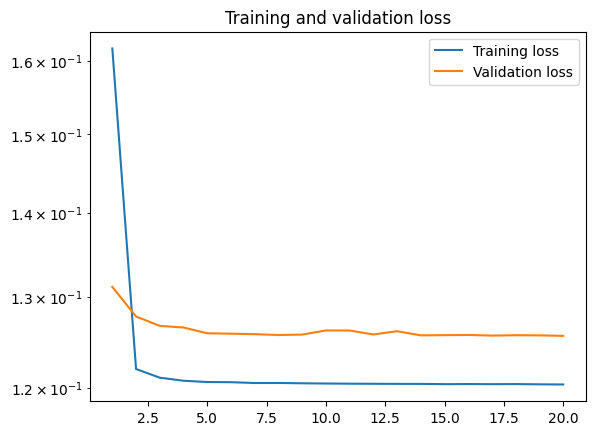

In [36]:
training_2(path_save_spectrogram, './weights', epochs= 20,batch_size=10)

In [12]:
#Helper Functions
def magnitude_db_and_phase_to_audio(frame_length, hop_length_fft, stftaudio_magnitude_db, stftaudio_phase):
    """This functions reverts a spectrogram to an audio"""

    stftaudio_magnitude_rev = librosa.db_to_amplitude(stftaudio_magnitude_db, ref=1.0)

    # taking magnitude and phase of audio
    audio_reverse_stft = stftaudio_magnitude_rev * stftaudio_phase
    audio_reconstruct = librosa.core.istft(audio_reverse_stft, hop_length=hop_length_fft, length=frame_length)

    return audio_reconstruct


def matrix_spectrogram_to_numpy_audio(m_mag_db, m_phase, frame_length, hop_length_fft)  :
    """This functions reverts the matrix spectrograms to numpy audio"""

    list_audio = []

    nb_spec = m_mag_db.shape[0]

    for i in range(nb_spec):

        audio_reconstruct = magnitude_db_and_phase_to_audio(frame_length, hop_length_fft, m_mag_db[i], m_phase[i])
        list_audio.append(audio_reconstruct)

    return np.vstack(list_audio)

def inv_scaled_ou(matrix_spec):
    "inverse global scaling apply to noise models spectrograms"
    matrix_spec = matrix_spec * 82 + 6
    return matrix_spec


In [3]:
import librosa
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import model_from_json
import soundfile as sf

def prediction(weights_path, audio_dir_prediction, dir_save_prediction, audio_input_prediction,
audio_output_prediction):
    loaded_model = model
    # load weights into new model
    
    print("Loaded model from disk")

    # Extracting noise and voice from folder and convert to numpy
    audio = audio_files_to_numpy(audio_dir_prediction, audio_input_prediction, sample_rate,
                                 frame_length, hop_length_frame, min_duration)

    dim_square_spec = int(n_fft / 2) + 1
    print(dim_square_spec)

    # Create Amplitude and phase of the sounds
    m_amp_db_audio,  m_pha_audio = numpy_audio_to_matrix_spectrogram(
        audio, dim_square_spec, n_fft, hop_length_fft)

    #global scaling to have distribution -1/1
    X_in = scaled_in(m_amp_db_audio)
    #Reshape for prediction
    X_in = X_in.reshape(X_in.shape[0],X_in.shape[1],X_in.shape[2],1)
    #Prediction using loaded network
    X_pred = loaded_model.predict(X_in)
    #Rescale back the noise model
    inv_sca_X_pred = inv_scaled_ou(X_pred)
    #Remove noise model from noisy speech
    X_denoise = m_amp_db_audio - inv_sca_X_pred[:,:,:,0]
    #Reconstruct audio from denoised spectrogram and phase
    print(X_denoise.shape)
    print(m_pha_audio.shape)
    print(frame_length)
    print(hop_length_fft)
    audio_denoise_recons = matrix_spectrogram_to_numpy_audio(X_denoise, m_pha_audio, frame_length, hop_length_fft)
    #Number of frames
    nb_samples = audio_denoise_recons.shape[0]
    #Save all frames in one file
    denoise_long = audio_denoise_recons.reshape(1, nb_samples * frame_length)*10
    # librosa.output.write_wav(dir_save_prediction + audio_output_prediction, denoise_long[0, :], 1000)
    sf.write(dir_save_prediction + audio_output_prediction, denoise_long[0, :], 8000, 'PCM_24')
    # wavfile.write(dir_save_prediction + audio_output_prediction, 1000, denoise_long[0,:])

#Predictions

In [ ]:
# Sample Noisy audio for Prediction
!gdown 1dNs_LqsPFY3R4lMBMfejHFJAn4zfsbtK
!gdown 1MsVGoIFR7350Hdeh3sJdqSzMsKuVoD-0

Downloading...

From: https://drive.google.com/uc?id=1dNs_LqsPFY3R4lMBMfejHFJAn4zfsbtK

To: /content/Final_Output_Noisy_Audio_Sample_Roshan (1).wav

100% 1.16M/1.16M [00:00<00:00, 154MB/s]

Downloading...

From: https://drive.google.com/uc?id=1MsVGoIFR7350Hdeh3sJdqSzMsKuVoD-0

To: /content/Dog Noisy.mp3

100% 57.3k/57.3k [00:00<00:00, 60.6MB/s]


In [64]:
!pip3 install pydub

In [65]:
from pydub import AudioSegment

In [4]:
def amplify(path):
  song = AudioSegment.from_wav(song)
  # Increase volume of the audio by 10 decibels
  louder = song+10
  louder.export(path+".wav")

In [8]:
#Playing the Noisy audio sample1
from IPython.display import Audio
Audio('/kaggle/input/letsdoit/MIXED/content/MIXED/combined_0004.wav')

## Prediction on audio sample 0004


In [17]:
!pip install git+https://github.com/openai/whisper.git
!sudo apt update && sudo apt install ffmpeg

  Cloning https://github.com/openai/whisper.git to /tmp/pip-req-build-zxnq0o1p
  Running command git clone --filter=blob:none --quiet https://github.com/openai/whisper.git /tmp/pip-req-build-zxnq0o1p
  Resolved https://github.com/openai/whisper.git to commit ba3f3cd54b0e5b8ce1ab3de13e32122d0d5f98ab
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.1/168.1 MB 9.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 37.5 MB/s eta 0:00:00
  Created wheel for openai-whisper: filename=openai_whisper-20231117-py3-none-any.whl size=802825 sha256=f602c810a9483970b52298bbe81efb3631bed9eb5722d0f35e0b600ad0dd9b2b
  Stored in directory: /tmp/pip-ephem-wheel-cache-nsp8gxn2/wheels/8b/6c/d0/622666868c179f156cf595c8b6f06f88bc5d80c4b31dccaa03
Successfully built openai-whisper
Get:1 https://packages.cloud.google.com/apt gcsfuse-focal InRelease

In [9]:
!whisper '/kaggle/input/letsdoit/ORIGINAL/content/ORIGINAL/original_0004.wav' --task translate

100%|████████████████████████████████████████| 461M/461M [00:04<00:00, 119MiB/s]
Detecting language using up to the first 30 seconds. Use `--language` to specify the language
Detected language: English
[00:00.000 --> 00:03.440]  Kids are talking by the door.


In [10]:
!whisper '/kaggle/input/letsdoit/MIXED/content/MIXED/combined_0004.wav' --task translate

Detecting language using up to the first 30 seconds. Use `--language` to specify the language
Detected language: Japanese
[00:00.000 --> 00:03.500]  Thank you for your viewing.


In [15]:
prediction('/kaggle/input', '/kaggle/working', '/kaggle/input/weights', ['combined_0004.wav'],
        'predicted_0004.wav')

In [18]:
!whisper '/kaggle/working/predicted_0004.wav' --task translate

100%|████████████████████████████████████████| 461M/461M [00:03<00:00, 148MiB/s]
Detecting language using up to the first 30 seconds. Use `--language` to specify the language
Detected language: English
[00:00.000 --> 00:03.000]  Kids are talking by door.
